***BIC Based Audio Segmentation***

When  the  input  audio  stream  is  modeled  as  a  Gaussian  process  in  the  cepstral  space,a maximum likelihood approach can be used to to detect turns of a Gaussian process,and the decision of a turn is based on the Bayesian Information Criterion (BIC) [1].  Inother  words,  the  BIC  procedure  is  to  choose  the  model  for  which  the  BIC  criterion  ismaximized

When  the  input  audio  stream  is  modeled  as  a  Gaussian  process  in  the  cepstral  space,a maximum likelihood approach can be used to to detect turns of a Gaussian process,and the decision of a turn is based on the Bayesian Information Criterion (BIC) [1].  Inother  words,  the  BIC  procedure  is  to  choose  the  model  for  which  the  BIC  criterion  ismaximized.

In [56]:
import librosa
import sklearn
import csv
import os
import numpy as np
import sys
from tqdm import tqdm
from matplotlib import pyplot as plt
import librosa.display

**1.1 Features Extraction**

1.  Prior  to  performing  the  audio  segmentation,  perform  the  standard  24-dimensional MFCC  feature  extraction  on  the  input  audio  file Interview.wav,  with  frame  width25ms and frame shift 10ms, to form the data samples, and plot the results

2.  To further enrich the features collection, add at least another 3 features of your choice,and plot the results.  Why do you choose those features?

In [57]:
def features_extracted(file):
    '''
    24 dimensional MFCC Feature Extraction

    input: audio file interview.wav
           frame width: 25 ms 
           shift: 10 ms

    '''
    signal, samplingrate = librosa.load(file)
    print(samplingrate)
    #frame size = 25ms and shift = 10ms 
    mfcc_features = librosa.feature.mfcc(y=signal, sr=samplingrate,n_mfcc=24,hop_length=int(0.010*samplingrate),n_fft=512) #,n_fft= 0.025*samplingrate
    #https://github.com/librosa/librosa/issues/584

    zero_crossings = librosa.zero_crossings(signal, pad=False)
    spectral_centroids = librosa.feature.spectral_centroid(signal, sr=samplingrate)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(signal, sr=samplingrate)[0]

    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    
    print(sum(zero_crossings))
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

    librosa.display.specshow(mfcc_features, sr=samplingrate, x_axis='time', ax=ax[0])
    ax[0].set(title='mfcc features')
    ax[0].label_outer()

    librosa.display.waveplot(signal, sr=samplingrate, alpha=0.4, ax= ax[1])
    plt.plot(t,sklearn.preprocessing.minmax_scale(spectral_rolloff, axis=0), color='g')
    ax[1].set(title='spectral rolloff')
    ax[1].label_outer() 

    #librosa.display.waveplot(signal, sr=samplingrate, alpha=0.4)
    plt.plot(t,sklearn.preprocessing.minmax_scale(spectral_centroids, axis=0), color='r')
    #ax[2].set(title='spectral centroids')
    #ax[2].label_outer() 

    plt.show()
    return mfcc_features, zero_crossings, spectral_centroids, spectral_rolloff




mfcc features
1. zero crossing rate: The zero crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back. This feature has been used heavily in both speech recognition and music information retrieval. It usually has higher values for highly percussive sounds like those in metal and rock.

2. spectral centroids: Similar to the zero crossing rate, there is a spurious rise in spectral centroid at the beginning of the signal. That is because the silence at the beginning has such small amplitude that high-frequency components have a chance to dominate.

3. Spectral rolloff : frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies.




22050
318860


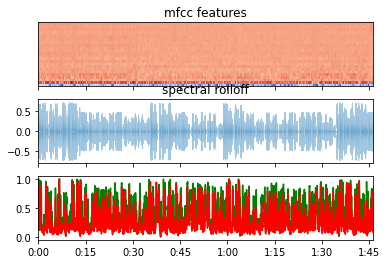

In [58]:
#Plotting the spectral features 
mfcc_features, zero_crossings, spectral_centroids, spectral_rolloff = features_extracted('Interview.wav')


In [59]:
features = []
features.append(np.mean(spectral_centroids))
features.append(np.mean(spectral_rolloff))
features.append(np.mean(zero_crossings))
for coefficient in mfcc_features:
    features.append(np.mean(coefficient))




**1.2 Segmentation using BIC**

 Implement an automatic audio segmentation using BIC based on the Section 3 of thispaper [2], where the basic of BIC is explained in Section 2.  Note that the objectiveis to identify all possible frames where there is a segment boundary.  In other words,audio segmentation aims at splitting an audio stream into acoustically homogeneoussegments.  Thus, the output of this implementation should be audio segments of theinput audio file that each segment contains only one homogeneous sound.
 
 As starting point, the window size of the data samples{x1,...,xn}can be set to 100frames, which can then be increased accordingly (if no segment boundary is found) asexplained in section 3.2.1 and 3.2.2 of the reference paper [2].  The penalty weight canfirst be set to 1, and modified to other values, if necessary, to improve the segmentationresult.


In [60]:
def compute_bic(mfcc_v, delta):
    m, n = mfcc_v.shape

    sigma0 = np.cov(mfcc_v).diagonal()
    eps = np.spacing(1)
    realmin = np.finfo(np.double).tiny
    det0 = max(np.prod(np.maximum(sigma0, eps)), realmin)

    flat_start = 5

    range_loop = range(flat_start, n, delta)
    x = np.zeros(len(range_loop))
    iter = 0
    for index in range_loop:
        part1 = mfcc_v[:, 0:index]
        part2 = mfcc_v[:, index:n]

        sigma1 = np.cov(part1).diagonal()
        sigma2 = np.cov(part2).diagonal()

        det1 = max(np.prod(np.maximum(sigma1, eps)), realmin)
        det2 = max(np.prod(np.maximum(sigma2, eps)), realmin)

        BIC = 0.5*(n*np.log(det0)-index*np.log(det1)-(n-index)*np.log(det2))-0.5*(m+0.5*m*(m+1))*np.log(n)
        x[iter] = BIC
        iter = iter + 1

    maxBIC = x.max()
    maxIndex = x.argmax()
    if maxBIC > 0:
        return range_loop[maxIndex]-1
    else:
        return -1


In [61]:
def speech_segmentation(mfccs):
    wStart = 0
    wEnd = 200
    wGrow = 200
    delta = 25

    m, n = mfccs.shape

    store_cp = []
    index = 0
    while wEnd < n:
        featureSeg = mfccs[:, wStart:wEnd]
        detBIC = compute_bic(featureSeg, delta)
        index = index + 1
        if detBIC > 0:
            temp = wStart + detBIC
            store_cp.append(temp)
            wStart = wStart + detBIC + 200
            wEnd = wStart + wGrow
        else:
            wEnd = wEnd + wGrow

    return np.array(store_cp)

In [62]:
import scipy.signal as signal

def vad(x,framelen = None, sr = None, frameshift = None, plot = False):
    if sr is None:
        sr = 16000
    if framelen is None:
        framelen = 256
    if frameshift is None:
        frameshift = 128
    amp_th1 = 8
    amp_th2 = 20
    zcr_th  = 5

    maxsilence = 8
    minlen     = 15
    status     = 0
    count      = 0
    silence    = 0
    try:
        x = x/np.absolute(x).max()
    except ValueError:
        pass
    print(x)
    tmp1 = enframe(x[0:(len(x)-1)], framelen, frameshift)
    tmp2 = enframe(x[1:(len(x)-1)], framelen, frameshift)
    signs = (tmp1* tmp2) < 0
    diffs = (tmp1 - tmp2) > 0.05
    zcr = np.sum(signs* diffs, axis=1)

    filter_coeff = np.array([1, -0.9375])
    pre_emphasis = signal.convolve(x,filter_coeff)[0:len(x)]
    amp = np.sum(np.absolute(enframe(pre_emphasis, framelen, frameshift)), axis=1)

    amp_th1 = min(amp_th1, amp.max()/ 3)
    amp_th2 = min(amp_th2, amp.max() / 8)

    x1 = []
    x2 = []
    t = 0

    for n in range(len(zcr)):
        if status == 0 or status == 1:
            if amp[n] > amp_th1:
                x1.append(max(n - count - 1, 1))
                status = 2
                silence = 0
                count = count + 1
            elif amp[n] > amp_th2 or zcr[n]>zcr_th:
                status = 1
                count = count + 1
            else:
                status = 0
                count = 0
            continue
        if status == 2:
            if amp[n] > amp_th2 or zcr[n]>zcr_th:
                count = count + 1
            else:
                silence = silence + 1
                if silence < maxsilence:
                    count = count + 1
                elif count < minlen:
                    status = 0
                    silence = 0
                    count = 0
                else:
                    status = 0
                    count = count - silence / 2
                    x2.append(x1[t] + count - 1)
                    t = t + 1

    if plot:
        plt.figure('speech endpoint detect')
        plt.plot(np.arange(0,len(x))/(float)(sr),x, "b-")
        len_endpoint = min(len(x1), len(x2))
        for i in range(len_endpoint):
            plt.vlines(x1[i]*frameshift/(float)(sr), -1, 1, colors="c", linestyles="dashed")
            plt.vlines(x2[i] * frameshift/(float)(sr), -1, 1, colors="r", linestyles="dashed")
        plt.xlabel("Time/s")
        plt.ylabel("Normalized Amp")
        plt.grid(True)
        plt.show()
    return x1,x2


def enframe(x,framelen, frameshift):
    xlen = len(x)
    nf   = (int)((xlen-framelen+frameshift)/frameshift)
    f    = np.zeros((nf,framelen), dtype=np.float32)
    indf = frameshift * (np.arange(0,nf)).reshape(nf,1)
    inds = np.arange(0,framelen).reshape(1,framelen)
    indall = np.tile(indf, (1, framelen))+np.tile(inds, (nf, 1))
    f = x[indall]
    return f

In [63]:
#a = bic_func(1,200,201,400,mfcc_features,1)
seg_point = speech_segmentation(mfcc_features/mfcc_features.max())
#print(seg_point)

[ 0.08493797  0.14962406  0.22632515 ... -0.0386232  -0.04046837
 -0.04402008]


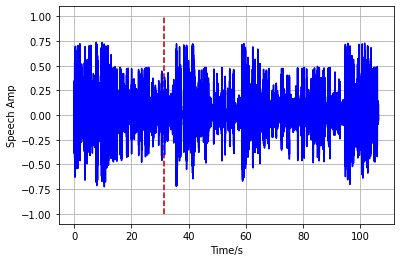

[-0.04981261 -0.05410625 -0.05565629 ...  0.00021195  0.0001555
  0.00041756]


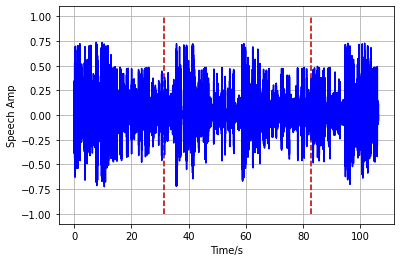

[ 7.7024521e-04  7.6083926e-04  4.9579784e-04 ... -6.5362257e-01
 -6.2412196e-01 -5.5125976e-01]


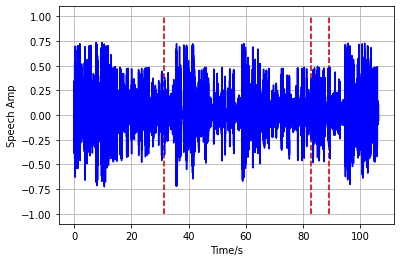

[-0.313028   -0.23983398 -0.15689903 ... -0.02044683 -0.02109852
 -0.0199826 ]


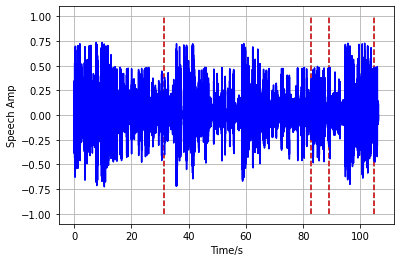

[-0.02713758 -0.02487209 -0.02169749 ...  0.16475634  0.20404628
  0.        ]


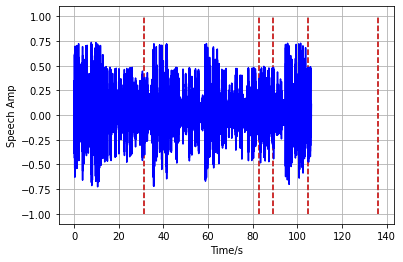

[]


/home/pankhuri/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pankhuri/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


ValueError: v cannot be empty

In [64]:
import shutil
import soundfile as sf

frame_size = 256 #256
frame_shift = 128 #10ms
y, sr = librosa.load('Interview.wav')

seg_point = seg_point * frame_shift
seg_point = np.insert(seg_point, 0, 0)
seg_point = np.append(seg_point, len(y))
rangeLoop = range(len(seg_point) - 1)

output_segpoint = []
for i in rangeLoop:
    temp = y[seg_point[i]:seg_point[i + 1]]
    # add a detection of silence before vad
    max_mean = np.mean(temp[temp.argsort()[-800:]])
    if max_mean < 0.005:
        continue
    #vad detect
    x1, x2 = vad(temp, sr=sr, framelen=frame_size, frameshift=frame_shift)
    if len(x1) == 0 or len(x2) == 0:
        continue
    elif seg_point[i + 1] == len(y):
        continue
    else:
        output_segpoint.append(seg_point[i + 1])

    plt.figure('speech segmentation plot')
    plt.plot(np.arange(0, len(y)) / (float)(sr), y, "b-")

    for i in range(len(output_segpoint)):
        plt.vlines(output_segpoint[i] / (float)(sr), -1, 1, colors="c", linestyles="dashed")
        plt.vlines(output_segpoint[i] / (float)(sr), -1, 1, colors="r", linestyles="dashed")
    plt.xlabel("Time/s")
    plt.ylabel("Speech Amp")
    plt.grid(True)
    plt.show()

    if not os.path.exists("save_audio"):
        os.makedirs("save_audio")
    else:
        shutil.rmtree("save_audio")
        os.makedirs("save_audio")
    save_segpoint = output_segpoint.copy()
    # Add the start and the end of the audio file
    save_segpoint.insert(0, 0)
    save_segpoint.append(len(y))
    for i in range(len(save_segpoint)-1):
        tempAudio = y[save_segpoint[i]:save_segpoint[i+1]]
        #librosa.output.write_wav("save_audio/%s.wav" % i, tempAudio, sr)
        sf.write("save_audio/%s.wav" % i, tempAudio, sr)



    


   

